In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import rpy2
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
import rpy2.robjects.numpy2ri
from rpy2.robjects.vectors import StrVector
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
packnames_to_install = ['conclust']
utils.install_packages(StrVector(packnames_to_install))
conclust = importr('conclust')
rpy2.robjects.numpy2ri.activate()

In [5]:
def get_r_matrix(np_array):
    return robjects.r.matrix(np_array, nrow=np_array.shape[0], ncol=np_array.shape[1])

In [6]:
a = [[0,0,0],[1,2,3],[7,8,9],[10,10,4],[-1,-1,-1],[1,1,1]]
data = get_r_matrix(np.array(a))
mustLink = get_r_matrix(np.array([[1,3]]))
cantLink = get_r_matrix(np.array([[1,3],[1,5]]))
print(data)
print(mustLink)
print(cantLink)

     [,1] [,2] [,3]
[1,]    0    0    0
[2,]    1    2    3
[3,]    7    8    9
[4,]   10   10    4
[5,]   -1   -1   -1
[6,]    1    1    1

     [,1] [,2]
[1,]    1    3

     [,1] [,2]
[1,]    1    3
[2,]    1    5



In [7]:
k = 2
pred = conclust.ckmeans(data, k, mustLink, cantLink)
# pred = conclust.mpckm(data, k, mustLink, cantLink)
print(pred)
print(np.vstack((np.array(range(1,len(a)+1)),pred)))

[1] 1 1 1 2 2 1

[[1. 2. 3. 4. 5. 6.]
 [1. 1. 1. 2. 2. 1.]]


In [8]:
def find_cantlink_constraints(y_trust):
    cantLink = []
    n = y_trust.shape[0]
    for i in range(n):
        for j in range(i+1,n):
            if y_trust[i]!=y_trust[j]:
                cantLink.append([i+1,j+1])
    return np.array(cantLink)

In [9]:
def pairwise_cluster(data, cantLink, k, mustLink=None, algo="COP"):
    pred = None
    print(data.shape,cantLink.shape)
    data = get_r_matrix(data)
    cantLink = get_r_matrix(cantLink)
    mustLink = get_r_matrix(np.array([[1,1]]))
    if algo=="COP":
        pred = conclust.ckmeans(data, k, mustLink, cantLink)
    elif algo=="MPCKM":
        pred = conclust.mpckm(data, k, mustLink, cantLink)
    return np.array(pred)

In [10]:
a = [[0,0,0],[1,2,3],[7,8,9],[10,10,4],[-1,-1,-1],[1,1,1]]
data = np.array(a)
mustLink = np.array([[1,3]])
cantLink = np.array([[1,3],[1,5]])
k=2
pairwise_cluster(data,cantLink,k)

(6, 3) (2, 2)


array([1., 1., 2., 2., 2., 1.])

# plotting

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram

In [12]:
# ----------------------------------------
# For plotting data
def plot_model(X_train, y_train, clf, X_trust=None, y_trust=None, title=None, 
													train_cluster_labels=None, trust_cluster_labels=None):
	
	pca = PCA(n_components=2)
	X_train_2d = pca.fit_transform(X_train)
	X_trust_2d = pca.transform(X_trust)

	# X = np.zeros((10000,2))
	# a = np.linspace(0,1,100)
	# b = np.linspace(0,1,100)
	# e, d = np.meshgrid(a, b)
	# X[:,0] = np.reshape(e,(10000,))
	# X[:,1] = np.reshape(d,(10000,))

	# Z = clf.predict(X)
	# probs = clf.predict_proba(K)[:, 1].reshape(e.shape)

	plt.figure()

	# Put the result into a color plot
	# Z = Z.reshape(e.shape)
	# plt.contour(e, d, probs, levels=[0.5])

	# Plot clusters
	if train_cluster_labels is not None:
		if trust_cluster_labels is not None:
			cluster_labels = np.concatenate([train_cluster_labels,trust_cluster_labels])
			X = np.vstack([X_train_2d, X_trust_2d])
			plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, marker='o', s=80)
		else:
			plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=train_cluster_labels, marker='o', s=80)

	# Plot the training points
	plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.Paired, marker='.')
	
	# Plot the trusted points
	if X_trust_2d is not None:
		plt.scatter(X_trust_2d[:, 0], X_trust_2d[:, 1], c=y_trust, cmap=plt.cm.Paired, marker='X')

	if title is not None:
		plt.title(str(title))

	plt.xlabel('x1')
	plt.ylabel('x2')
	plt.draw()

Plotting Dendrogram...
https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py

In [13]:
def plot_dendrogram(model, **kwargs):
    
    plt.title('Hierarchical Clustering Dendrogram')
    
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    plt.show()

# GermanLoan

In [14]:
import csv
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics.pairwise import rbf_kernel
import sys
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [15]:
# read dataset
col_names = ['Checking Status', 'Duration','Credit History', 'Credit Amt','Purpose', 
              'Saving acc', 'Present emp since', 'Installment Rate',
             'Personal Status', 'Age', 'Other debtors', 'Present Residence since', 'Property',
              'Other installment plans', 'Housing', 'Existing credits',
             'Job', 'Num People', 'Telephone', 'Foreign Worker','a','b','c','d','Approval Status']

numerical = ['Duration','Credit Amt','Age']

print("Reading dataset...")
all_data = pd.read_csv("germanloan.csv", names=col_names)
print(all_data.shape)

n = all_data.shape[0]
X = all_data[all_data.columns.difference(['Approval Status'])]
y = all_data['Approval Status']
print(X.shape,y.shape)

Reading dataset...
(1000, 25)
(1000, 24) (1000,)


In [16]:
all_data.head(30)

,Checking Status,Duration,Credit History,Credit Amt,Purpose,Saving acc,Present emp since,Installment Rate,Personal Status,Age,...,Existing credits,Job,Num People,Telephone,Foreign Worker,a,b,c,d,Approval Status
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2
5,4,36,2,91,5,3,3,4,4,35,...,0,0,1,0,0,0,0,1,0,1
6,4,24,2,28,3,5,3,4,2,53,...,0,0,1,0,0,1,0,0,1,1
7,2,36,2,69,1,3,3,2,3,35,...,0,1,1,0,1,0,0,0,0,1
8,4,12,2,31,4,4,1,4,1,61,...,0,0,1,0,0,1,0,1,0,1
9,2,30,4,52,1,1,4,2,3,28,...,1,0,1,0,0,1,0,0,0,2


In [17]:
# Set 1=good, -1=bad in y
y[y==2] = -1

In [18]:
# scaler = StandardScaler()
# X.loc[:,['Duration','Credit Amt']] = scaler.fit_transform(X.loc[:,['Duration','Credit Amt']].astype('float64'))

In [19]:
# partition dataset on the basis of age, threshold = 25
X_y = X[X['Age']<=25]
X_o = X[X['Age']>25]
y_y = y[X['Age']<=25]
y_o = y[X['Age']>25]
print(X_y.shape, X_o.shape)

(190, 24) (810, 24)


In [20]:
X_y.head(2)

,Age,Checking Status,Credit Amt,Credit History,Duration,Existing credits,Foreign Worker,Housing,Installment Rate,Job,...,Present Residence since,Present emp since,Property,Purpose,Saving acc,Telephone,a,b,c,d
1,22,2,60,2,48,0,0,1,2,0,...,1,2,1,1,3,0,1,0,0,1
10,25,2,13,2,12,1,1,1,1,0,...,1,2,1,1,2,0,0,0,0,1


In [21]:
# Remove age as a feature
del X_y['Age']
del X_o['Age']

print(X_y.shape, X_o.shape)

(190, 23) (810, 23)


In [22]:
# Converting to numpy arrays
X_young = X_y.values
X_old = X_o.values
y_young = y_y.values
y_old = y_o.values

In [23]:
print(X_young.shape, X_old.shape)

(190, 23) (810, 23)


In [24]:
# Random arrays for partitioning into A,B,C datasets
np.random.seed(123)
young = np.random.permutation(np.arange(X_young.shape[0]))
old = np.random.permutation(np.arange(X_old.shape[0]))

In [25]:
# --------------------------------------------------------------
print("Creating datasets A, B and C...")
# Create dataset A (trusted dataset)
X_A = np.concatenate((X_young[young[:20],:],X_old[old[:20],:]))
y_A = np.concatenate((y_young[young[:20]],y_old[old[:20]]))
# print(X_A.shape,y_A.shape)

# Create dataset B (buggy dataset)
X_B = np.concatenate((X_young[young[20:190],:],X_old[old[20:190],:]))
y_B = np.concatenate((y_young[young[20:190]],y_old[old[20:190]]))
# print(X_B.shape,y_B.shape)

# Create dataset C (ground truth)
X_C = X_old[old[190:],:]
y_C = y_old[old[190:]]
# print(X_C.shape,y_C.shape)

Creating datasets A, B and C...


In [26]:
# --------------------------------------------------------------
print("Training Model on dataset C...")

# the learner is hard coded to be logistic regression
lam = 5e-3	# L2 regularization weight of learner

# Training model f* on dataset C
clf = LogisticRegression(solver='lbfgs', C=lam)

clf = AdaBoostClassifier()


clf.fit(X_C, y_C)
y_C_pred = clf.predict(X_C)

print("Creating trusted labels for dataset A...")
y_A_pred = clf.predict(X_A)

print("Number of label changes made in Dataset A to make it trusted: %d"%np.count_nonzero(y_A-y_A_pred)),"\n"
y_A = y_A_pred

Training Model on dataset C...
Creating trusted labels for dataset A...
Number of label changes made in Dataset A to make it trusted: 11


# experiments

In [27]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.linear_model import LogisticRegression
from itertools import product
import matplotlib.pyplot as plt

In [28]:
def plot_prcurve(pr_data):
    pr_data = np.array(pr_data)
    pr_data = pr_data[pr_data[:,1].argsort()]
    
    anno=None
    if pr_data.shape[1]==3:
        anno = pr_data[:,2].astype('int')
    
    plt.figure()
    plt.plot(pr_data[:,1], pr_data[:,0]) 
    
    
    if anno is not None:
        i = 0
        for xy in zip(pr_data[:,1], pr_data[:,0]):
            plt.annotate(anno[i], xy=xy)
            i +=1
        
    plt.xlabel('Recall') 
    plt.ylabel('Precision') 
    plt.title('PR curve') 
    
    

In [29]:
# Works only for binary classification!
def find_precision_recall(y_train, y_pred, y_train_mod):
    
    true_bugs = y_train-y_pred
    true_bugs[true_bugs!=0] = 1
    pred_bugs = y_train-y_train_mod
    pred_bugs[pred_bugs!=0] = 1
        
    num_true_bugs = np.sum(true_bugs)
    num_pred_bugs = np.sum(pred_bugs)
    
    # Calculating True positives
    t = true_bugs + pred_bugs
    num_tp = np.sum(t[t==2])//2
    
    # Calculating False positives and False Negatives
    t = true_bugs - pred_bugs
    num_fp = -np.sum(t[t==-1])
    num_fn = np.sum(t[t==1])
    
    if num_tp+num_fp>0:
        precision = num_tp / (num_tp+num_fp)
    else:
        precision = 1.0
    if num_tp+num_fn>0:
        recall = num_tp / (num_tp+num_fn)
    else:
        recall = 0.0
    
    return precision, recall, {'true':num_true_bugs,'pred':num_pred_bugs,'tp':num_tp,'fp':num_fp,'fn':num_fn}
    

In [30]:
def evaluate_model(y_train,y_pred,y_train_mod, y_mod_pred):
# 	print("Number of label changes made in dataset: %d" % np.count_nonzero(y_train - y_train_mod))
# 	print("Model Accuracy w.r.t. Original dataset: ", 
#           np.count_nonzero((y_train - y_mod_pred)==0)*100.0/y_train.shape[0])
# 	print("Model Accuracy w.r.t. Modified dataset: ", 
#           np.count_nonzero((y_train_mod - y_mod_pred)==0)*100.0/y_train.shape[0],"\n")
    
    p,r,_ = find_precision_recall(y_train,y_pred,y_train_mod)
    return [p,r]

In [31]:
def check_trusted_items(X_train,y_train,X_trust,y_trust, clf, combo=None, 
						train_cluster_labels=None, trust_cluster_labels=None, plot=False):

	clf.fit(X_train, y_train)
	y_train_pred = clf.predict(X_train)

	y_trust_pred = clf.predict(X_trust)

	# print("Plotting...")

	if np.array_equal(y_trust, y_trust_pred):
		print ("All trusted items predicted correctly by model, combo:",combo)
		if plot:
			plotting.plot_model(X_train, y_train, X_trust, y_trust, str(combo)+" Good", 
													train_cluster_labels, trust_cluster_labels)
		check = True
	else:
# 		print ("%d trusted items were incorrectly predicted. Continuing experiment..."% np.count_nonzero(y_trust-y_trust_pred))
		if plot:
			plot_model(X_train, y_train, clf, X_trust, y_trust, str(combo)+" Bad", 
		 											train_cluster_labels, trust_cluster_labels)
		check = False
	return clf, y_train_pred, y_trust_pred, check, np.count_nonzero(y_trust-y_trust_pred)

In [32]:
def modify_labels(K, y_train, train_cluster_labels, combo, max_changes=np.inf):
	
	y_train_mod = np.copy(y_train)
	for i in range(K):
		y_train_mod[train_cluster_labels==i] = combo[i]
	
	num_changes = np.count_nonzero(y_train - y_train_mod)
	if num_changes>max_changes:
		# print(combo,"Too many changes to dataset:",num_changes,"\n")
		return None
	else:
# 		print(combo,"Changes to dataset:",num_changes,"\n")
		return y_train_mod

In [33]:
def modify_labels_trust(y_train,y_trust,y_trust_pred,train_cluster_labels,trust_cluster_labels,max_changes=np.inf):
	y_train_mod = np.copy(y_train)
	for i in range(len(y_trust_pred)):
		if y_trust_pred[i]!=y_trust[i]:
# 			print("Set Cluster",trust_cluster_labels[i],"to",y_trust[i])
			y_train_mod[train_cluster_labels==trust_cluster_labels[i]] = y_trust[i]
	num_changes = np.count_nonzero(y_train - y_train_mod)
	if num_changes>max_changes:
		print("Too many changes to dataset:",num_changes,"\n")
		return None
	else:
		return y_train_mod


In [34]:
def modify_labels_flip_one(y_train,train_cluster_labels,cluster_label,new_label,max_changes=np.inf):
	y_train_mod = np.copy(y_train)
    
	y_train_mod[train_cluster_labels==cluster_label] = new_label
    
	num_changes = np.count_nonzero(y_train - y_train_mod)
	if num_changes>max_changes:
		print("Too many changes to dataset:",num_changes,"\n")
		return None
	else:
		return y_train_mod


In [35]:
def cluster_data(X_train, y_train, X_trust, y_trust, clf, 
                 min_K, max_K, max_changes=np.inf, combo_mode="trusted", plot=False, cluster_with_labels=False):
    
    pr_data = []
    anno = []
    
    label_set = list(set(y_train))

    # Visualize original dataset
    print("Running Model without any modifications to dataset...")
    plt.show() 

    clf, y_pred, y_trust_pred, check, incorrect = check_trusted_items(X_train,y_train,X_trust,y_trust,clf, plot=plot)
    print("Number of bugs: %d" % np.count_nonzero(y_train - y_pred))
#     pr_data.append(evaluate_model(y_train,y_pred,y_train, y_pred))

    if check:
        print("All trusted items classified correctly using original dataset! \n")

    print()

    if combo_mode=="all":
        print("Trying all labeling of clusters, from K = %d to %d\n"%(min_K,max_K))
    elif combo_mode=="trusted":
        print("Modifying only labels of clusters containing mislabeled trusted items, from K = %d to %d\n"%(min_K,max_K))
    elif combo_mode=="flip_one":
        print("Flipping labels of datapoints, one cluster at a time, from K = %d to %d\n"%(min_K,max_K))
    
        combo_mode = "trusted"
# combo_mode = "flip_one"
    if cluster_with_labels:
        X_train_cluster = np.hstack((X_train, np.reshape(y_train,(y_train.shape[0],1))))
        X_trust_cluster = np.hstack((X_trust, np.reshape(y_trust,(y_trust.shape[0],1))))
    else:
        X_train_cluster = np.copy(X_train)
        X_trust_cluster = np.copy(X_trust)
        
    X_train_and_trust = np.vstack([X_train_cluster, X_trust_cluster])

    categorical = [True for i in range(X_train_cluster.shape[1])]
    categorical[1] = False
    categorical[3] = False
     
    
    for K in range(min_K,max_K+1):
        
        cantLink = find_cantlink_constraints(y_trust)
        cluster_labels = pairwise_cluster(X_train_and_trust, cantLink, K) 
        
        train_cluster_labels = cluster_labels[:X_train.shape[0]]
        trust_cluster_labels = cluster_labels[X_train.shape[0]:]
        train_counts = []
        trust_counts = []
        for i in range(K):
            train_counts.append(np.sum(train_cluster_labels==i))
            trust_counts.append(np.sum(trust_cluster_labels==i))
        print("Clustering distribution:",train_counts,trust_counts)  
        
        if combo_mode=="all":
            print("Brute Force Clustering for K=%d"%K)
            all_combos = list(product(label_set, repeat=K)) 
            # this list contains every possible combination of labels for each cluster
            
            for combo in all_combos:
                if len(set(combo))<=1:
                    continue

                
                y_train_mod = modify_labels(K, y_train, train_cluster_labels, combo, max_changes=max_changes)
                if y_train_mod is None:
                    continue

#                 print(combo,":",)
                clf, y_mod_pred, _, check, incorrect = check_trusted_items(X_train,y_train_mod,X_trust,y_trust, clf, combo, 
                                                                train_cluster_labels, trust_cluster_labels)
                pr_data.append(evaluate_model(y_train,y_pred,y_train_mod, y_mod_pred)+[incorrect])


                
        
        elif combo_mode=="trusted":
            print("Trusted Clustering for K=%d"%K)
            y_train_mod = modify_labels_trust(y_train,y_trust,y_trust_pred,train_cluster_labels,trust_cluster_labels,max_changes=max_changes)
            if y_train_mod is None:
                continue

            # print(y_trust_pred,y_trust)
            # print "List of points whose labels were changed:",[i for i in range(len(y_train)) if y_train[i]!=y_train_mod[i]]
            # print(train_cluster_labels,trust_cluster_labels)


            clf, y_mod_pred, _, check, incorrect = check_trusted_items(X_train,y_train_mod,X_trust,y_trust, clf, 
                                                        "Trusted clustering: %d"%K, train_cluster_labels, 
                                                        trust_cluster_labels, plot=plot)
            
            pr_data.append(evaluate_model(y_train,y_pred,y_train_mod, y_mod_pred)+[incorrect])


            
        
        elif combo_mode=="flip_one":
            print("Flip-One Clustering for K=%d"%K)
            
            # For each cluster, try setting all possible labels for each cluster, one at a time, while keeping
            # the labels of datapoints in other clusters to be the same
            
            for cluster_label in range(K):
                for label in label_set:
                    y_train_mod = modify_labels_flip_one(y_train,train_cluster_labels,cluster_label,label,
                                                         max_changes=max_changes)
#                     print("Modified dataset by setting all labels in cluster %d to %d"%(cluster_label,label))
                    
                    if y_train_mod is None:
                        continue
                        
                    combo = "K=%d, Cluster %d to %d"%(K,cluster_label,label)

                    clf, y_mod_pred, _, check, incorrect = check_trusted_items(X_train,y_train_mod,X_trust,y_trust, clf, combo, 
                                                                    train_cluster_labels, trust_cluster_labels, plot=plot)
                    
                    pr_data.append(evaluate_model(y_train,y_pred,y_train_mod, y_mod_pred)+[incorrect])
                    
    plot_prcurve(pr_data)        

    plt.show()

## Running the code...

In [40]:
max_changes = np.inf
combo_mode = "all"
combo_mode = "trusted"
combo_mode = "flip_one"
plot = False 
min_K = 2
max_K = 30
cluster_with_labels = False
# cluster_with_labels = True

Running Model without any modifications to dataset...
Number of bugs: 57

Flipping labels of datapoints, one cluster at a time, from K = 2 to 30

(380, 23) (279, 2)
Clustering distribution: [0, 103] [0, 8]
Trusted Clustering for K=2
(380, 23) (279, 2)
Clustering distribution: [0, 138, 45] [0, 12, 6]
Trusted Clustering for K=3
(380, 23) (279, 2)
Clustering distribution: [0, 125, 46, 153] [0, 11, 5, 21]
Trusted Clustering for K=4
(380, 23) (279, 2)
Clustering distribution: [0, 76, 106, 46, 16] [0, 10, 13, 4, 3]
Trusted Clustering for K=5
(380, 23) (279, 2)
Clustering distribution: [0, 14, 42, 35, 104, 55] [0, 2, 4, 5, 12, 5]
Trusted Clustering for K=6
(380, 23) (279, 2)
Clustering distribution: [0, 31, 57, 41, 59, 14, 30] [0, 4, 5, 6, 9, 2, 2]
Trusted Clustering for K=7
(380, 23) (279, 2)
Clustering distribution: [0, 22, 36, 33, 45, 81, 13, 52] [0, 4, 4, 3, 5, 9, 1, 6]
Trusted Clustering for K=8
(380, 23) (279, 2)
Clustering distribution: [0, 25, 44, 14, 31, 45, 41, 46, 27] [0, 3, 5, 2, 

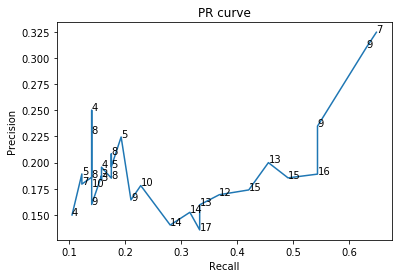

In [41]:
# --------------------------------------------------------------
# Experimenting with clustering

cluster_data(X_B, y_B, X_A, y_A, clf, min_K=min_K, max_K=max_K, 
             max_changes=max_changes,combo_mode=combo_mode, plot=plot, 
             cluster_with_labels=cluster_with_labels)